We've been trying to use the analytical (Buckley-Leverett) solution of the two-phase flow in porous media to fit the Corey-type relative permeability model to the experimental oil recovery data. In this post, I'm going to compare the numerical solution of the same model with the analytical results. You can find the codes that I have written in [this github repository](https://github.com/simulkade/peteng). Here, I only call the codes and compare the results.

In [21]:
# load the input parameters and the functions
using Roots, PyPlot, Dierckx, JFVM
import JSON, JLD
include("../functions/rel_perms.jl")
include("../functions/forced_imbibition_corey.jl")
include("../functions/frac_flow_funcs.jl")
IJulia.clear_output()

0

The input parameters are stored in the `input_params_BL.jld` file, that can be loaded by

In [4]:
JLD.@load "../results/input_params_BL.jld"

14-element Array{Symbol,1}:
 :L_core  
 :kro0    
 :krw0    
 :mu_oil  
 :mu_water
 :no      
 :nw      
 :perm_ave
 :poros   
 :pv_inj  
 :sor     
 :swc     
 :swi     
 :u_inj   

Now we can run the functions for the analytical and numerical solutions:

In [22]:
# call the functions
# numerical solution (finite volume)
(t_num, R_num, dp_h, sw_prf)=forced_imb_impes(mu_water, mu_oil, u_inj, 
    poros, perm_ave, swc, sor, kro0, no,
    krw0,nw, swi, 1.0, L_core, pv_inj, Nx=50)
IJulia.clear_output()

0

In [17]:
# Analytical solution (BL)
(xt_shock, sw_shock, xt_prf, sw_prf, t_anal, p_inj, R_anal) = frac_flow_wf(
  muw=mu_water, muo=mu_oil, ut=u_inj, phi=poros,
  k=perm_ave, swc=swc, sor=sor, kro0=kro0, no=no, 
  krw0=krw0, nw=nw, sw0=swi, sw_inj=1.0, L=L_core, pv_inj=pv_inj)
IJulia.clear_output() # only to clear the output from the previous function

0

Now, we can plot the results and compare the solutions:

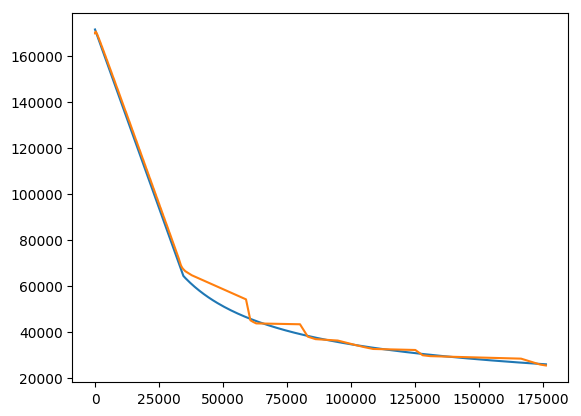

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f849666d390>
 PyObject <matplotlib.lines.Line2D object at 0x7f849666d590>

In [24]:
plot(t_anal, p_inj, t_num, dp_h)

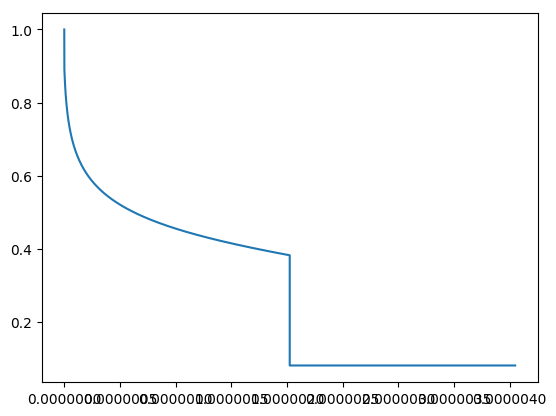

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8499172bd0>

In [18]:
plot(xt_prf, sw_prf)

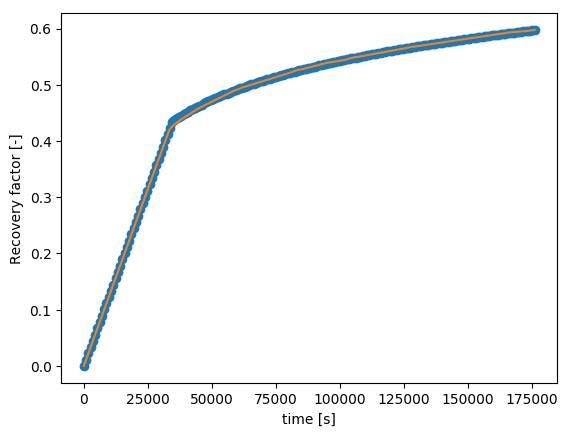

0

In [9]:
plot(t_anal, R_anal, "o", t_num, R_num)
xlabel("time [s]")
ylabel("Recovery factor [-]")
IJulia.clear_output()

It seems that the match very well. But if we zoom on the recovery plot close to the water breakthrough time,

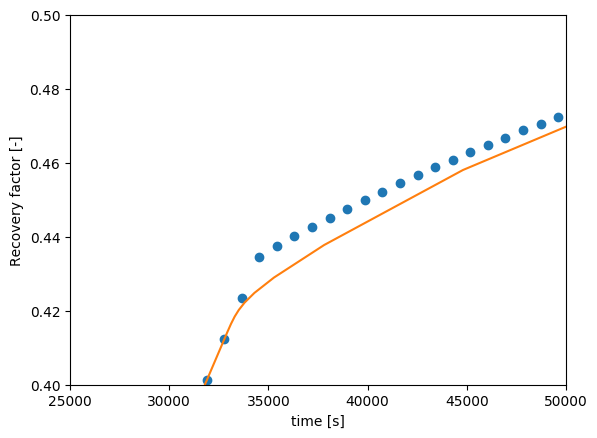

0

In [10]:
plot(t_anal, R_anal, "o", t_num, R_num)
xlabel("time [s]")
ylabel("Recovery factor [-]")
axis([25000, 50000, 0.40, 0.5])
IJulia.clear_output()

we can see that there is roughly 1 percent underestimation of the recovery factor by the numerical method. One reason is the numerical diffusion in the upwind scheme that I have used in my numerical solution. With this diffusion, the front is not sharp anymore and the water breakthrough (decrease in the slope of the recovery curve from the linear trend) happens a bit earlier in time. Let's test it by plotting the saturation profiles:

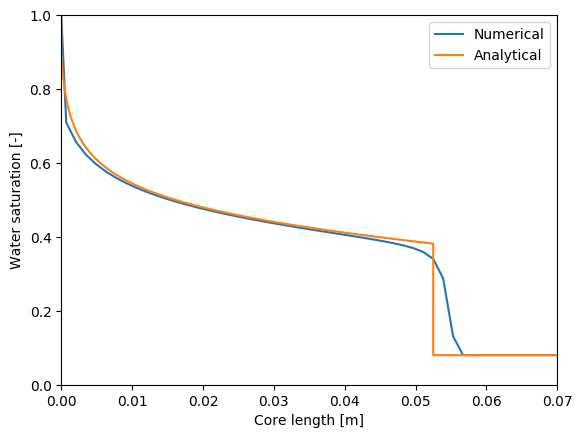

0

In [11]:
pv_inj2 = 0.3
(t_num, R_num, sw_prf_num)=forced_imb_impes(mu_water, mu_oil, u_inj, 
    poros, perm_ave, swc, sor, kro0, no,
    krw0,nw, swi, 1.0, L_core, pv_inj2, Nx=50)

# Analytical solution (BL)
(xt_shock, sw_shock, xt_prf, sw_prf, t_anal, p_inj, R_anal) = frac_flow_wf(
  muw=mu_water, muo=mu_oil, ut=u_inj, phi=poros,
  k=perm_ave, swc=swc, sor=sor, kro0=kro0, no=no, 
  krw0=krw0, nw=nw, sw0=swi, sw_inj=1.0, L=L_core, pv_inj=pv_inj2)
visualizeCells(sw_prf_num)
plot(xt_prf*t_anal[end], sw_prf)
axis([0, L_core, 0, 1.0])
legend(["Numerical", "Analytical"])
xlabel("Core length [m]")
ylabel("Water saturation [-]")
IJulia.clear_output() # only to clear the output from the previous function

We can clearly see that the extra numerical diffusion causes the water front to move faster resulting in an earlier water breakthrough. We can decrease this diffusion by refining the grid:

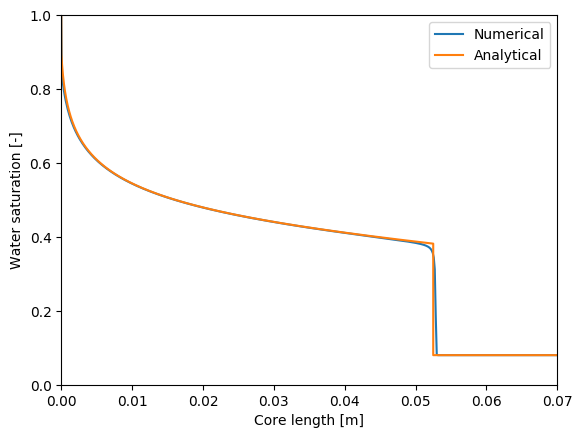

0

In [12]:
(t_num, R_num, sw_prf_num)=forced_imb_impes(mu_water, mu_oil, u_inj, 
    poros, perm_ave, swc, sor, kro0, no,
    krw0,nw, swi, 1.0, L_core, pv_inj2, Nx=500)
visualizeCells(sw_prf_num)
plot(xt_prf*t_anal[end], sw_prf)
axis([0, L_core, 0, 1.0])
legend(["Numerical", "Analytical"])
xlabel("Core length [m]")
ylabel("Water saturation [-]")
IJulia.clear_output()

Now, we can see that the numerical solution is very close to the analytical solution. This must give a better match for the recovery curves as well:

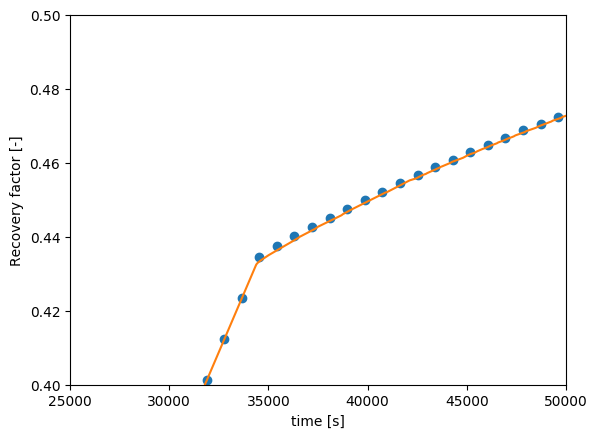

0

In [13]:
# numerical solution (finite volume)
(t_num, R_num, sw_prf)=forced_imb_impes(mu_water, mu_oil, u_inj, 
    poros, perm_ave, swc, sor, kro0, no,
    krw0,nw, swi, 1.0, L_core, pv_inj, Nx=500)

# Analytical solution (BL)
(xt_shock, sw_shock, xt_prf, sw_prf, t_anal, p_inj, R_anal) = frac_flow_wf(
  muw=mu_water, muo=mu_oil, ut=u_inj, phi=poros,
  k=perm_ave, swc=swc, sor=sor, kro0=kro0, no=no, 
  krw0=krw0, nw=nw, sw0=swi, sw_inj=1.0, L=L_core, pv_inj=pv_inj)
plot(t_anal, R_anal, "o", t_num, R_num)
xlabel("time [s]")
ylabel("Recovery factor [-]")
axis([25000, 50000, 0.40, 0.5])
IJulia.clear_output()

## sensitivity analysis
Effect of relperm parameters on the total recovery factor, compare to a base case:

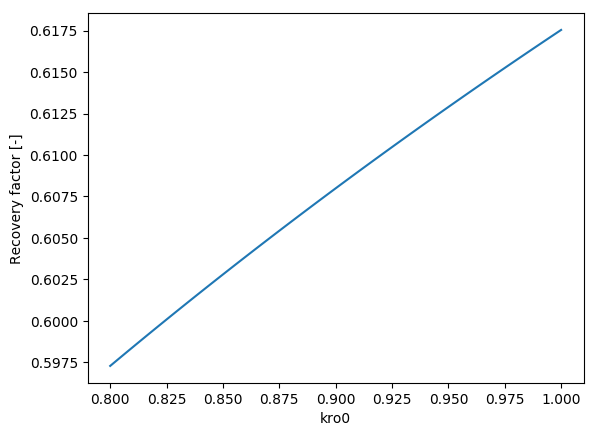

0

In [17]:
n_points = 100
R_fact   = zeros(n_points)
kro0_range = linspace(kro0, max(kro0, 1.0), n_points)
for i = 1:n_points
    # Analytical solution (BL)
    (xt_shock, sw_shock, xt_prf, sw_prf, t_anal, p_inj, R_anal) = frac_flow_wf(
      muw=mu_water, muo=mu_oil, ut=u_inj, phi=poros,
      k=perm_ave, swc=swc, sor=sor, kro0=kro0_range[i], no=no, 
      krw0=krw0, nw=nw, sw0=swi, sw_inj=1.0, L=L_core, pv_inj=pv_inj)
    R_fact[i] = R_anal[end]
end
plot(kro0_range, R_fact, "-")
xlabel("kro0")
ylabel("Recovery factor [-]")
# axis([25000, 50000, 0.40, 0.5])
IJulia.clear_output()

In [14]:
kro0

0.8

In [ ]:
(t_num, R_num, sw_prf)=forced_imb_impes(mu_water, mu_oil, u_inj, 
    poros, perm_ave, swc, sor, kro0, no,
    krw0,nw, swi, 1.0, L_core, pv_inj, Nx=500)